# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [2]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from torch_geometric.data import Data
import torch
import torch.nn as nn
import dgl
from dgl.nn import GraphConv
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from sklearn.metrics.pairwise import cosine_similarity

from torch_geometric.nn import GCNConv

In [3]:
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])

In [8]:
print(node_info.shape)
node_info.head(-5)

(3597, 932)


,1,2,3,4,5,6,7,8,9,10,...,923,924,925,926,927,928,929,930,931,932
0,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


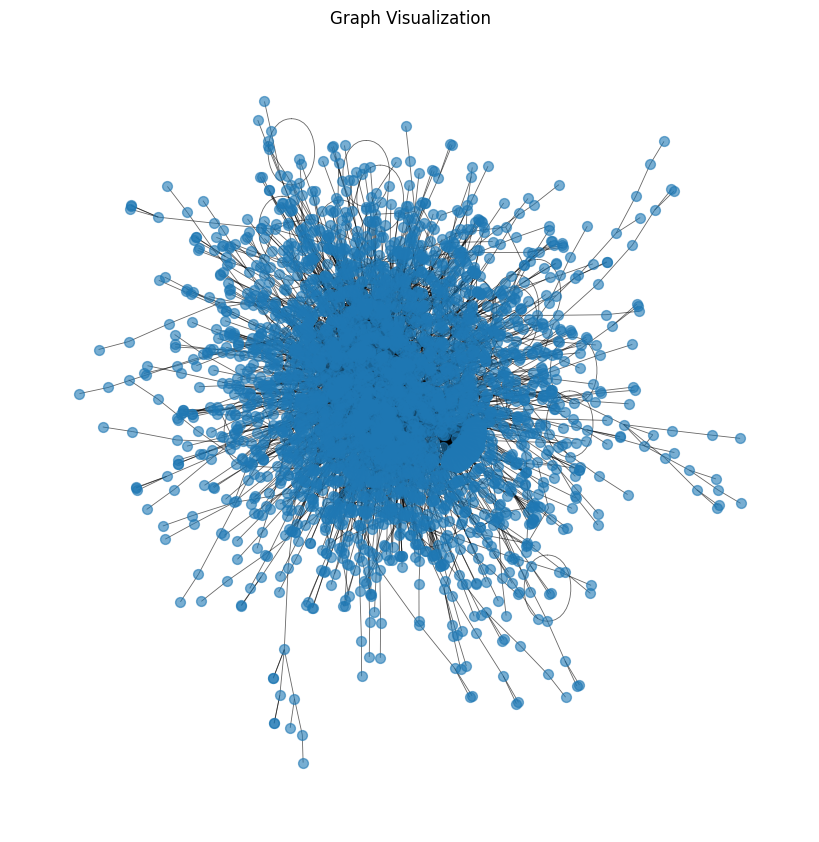

In [4]:
edges = train_set[train_set['label'] == 1][['source', 'target']].values.tolist()

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_size = 50, alpha = 0.6, width = 0.6)
plt.title("Graph Visualization")
plt.show()

Number of nodes: 3597
Number of edges: 5248


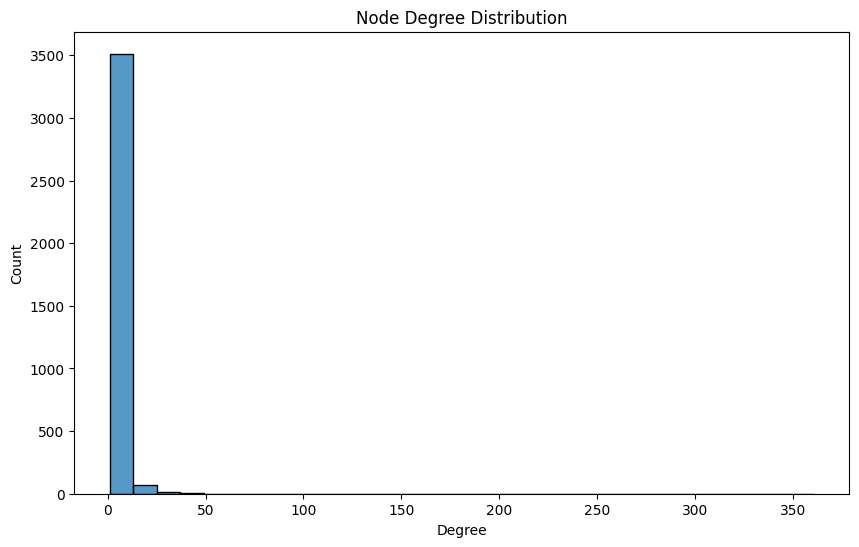

label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [62]:
# Graph Information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Node Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
sns.histplot(degrees, kde=False, bins=30)
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

# Label distribution
print(train_set['label'].value_counts(normalize=True))

## II - Feature Engineering

In [5]:
# Cosine Similarity
def calculate_cosine_similarity(node_encodings, source_node, target_node):
    source_vector = node_encodings.loc[source_node].values.reshape(1, -1)
    target_vector = node_encodings.loc[target_node].values.reshape(1, -1)
    return cosine_similarity(source_vector, target_vector)[0][0]

train_set['cosine_similarity'] = train_set.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)

In [6]:
def common_neighbors(G, u, v):
        return len(list(nx.common_neighbors(G, u, v)))

train_set['common_neighbors'] = train_set.apply(lambda row: common_neighbors(G, row['source'], row['target']), axis=1)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors
0,939,3809,1,0.000000,0
1,2442,5784,1,0.308607,1
2,179,3809,1,0.000000,2
3,857,2280,1,0.000000,0
4,1358,5722,1,0.288675,0


In [7]:
# Add node degree for source and target to the train_set
degree_dict = dict(G.degree())
train_set['source_degree'] = train_set['source'].apply(lambda x: degree_dict.get(x, 0))
train_set['target_degree'] = train_set['target'].apply(lambda x: degree_dict.get(x, 0))


# Calculate Jaccard coefficient
train_set['jaccard_coefficient'] = [list(nx.jaccard_coefficient(G, [(row['source'], row['target'])]))[0][2] for index, row in train_set.iterrows()]

train_set.head()

,source,target,label,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient
0,939,3809,1,0.000000,0,1,361,0.00000
1,2442,5784,1,0.308607,1,7,4,0.10000
2,179,3809,1,0.000000,2,4,361,0.00551
3,857,2280,1,0.000000,0,7,17,0.00000
4,1358,5722,1,0.288675,0,2,13,0.00000


In [8]:
test_set['cosine_similarity'] = test_set.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)
test_set['common_neighbors'] = test_set.apply(lambda row: common_neighbors(G, row['source'], row['target']), axis=1)
test_set['source_degree'] = test_set['source'].apply(lambda x: degree_dict.get(x, 0))
test_set['target_degree'] = test_set['target'].apply(lambda x: degree_dict.get(x, 0))
test_set['jaccard_coefficient'] = [list(nx.jaccard_coefficient(G, [(row['source'], row['target'])]))[0][2] for index, row in test_set.iterrows()]
test_set.head()

,source,target,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient
0,3425,4524,0.204124,0,1,2,0.0
1,1620,2617,0.000000,0,2,2,0.0
2,4832,6317,0.182574,0,1,2,0.0
3,4984,7298,0.471405,0,1,4,0.0
4,385,5481,0.353553,0,2,1,0.0


In [9]:
unique_nodes = set([edge[0] for edge in edges] + [edge[1] for edge in edges])

# Create a mapping from old IDs to new consecutive IDs
node_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_nodes))}

# Remap edges using the new node IDs
remapped_edges = [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in edges]

edge_index = torch.tensor(remapped_edges, dtype=torch.long).t().contiguous()


In [10]:
num_features = node_info.shape[1]
num_nodes = len(unique_nodes)
x = torch.zeros((num_nodes, num_features), dtype=torch.float)

# Fill the feature matrix
for old_id, new_id in node_mapping.items():
    if old_id in node_info.index:
        x[new_id] = torch.tensor(node_info.loc[old_id].values, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

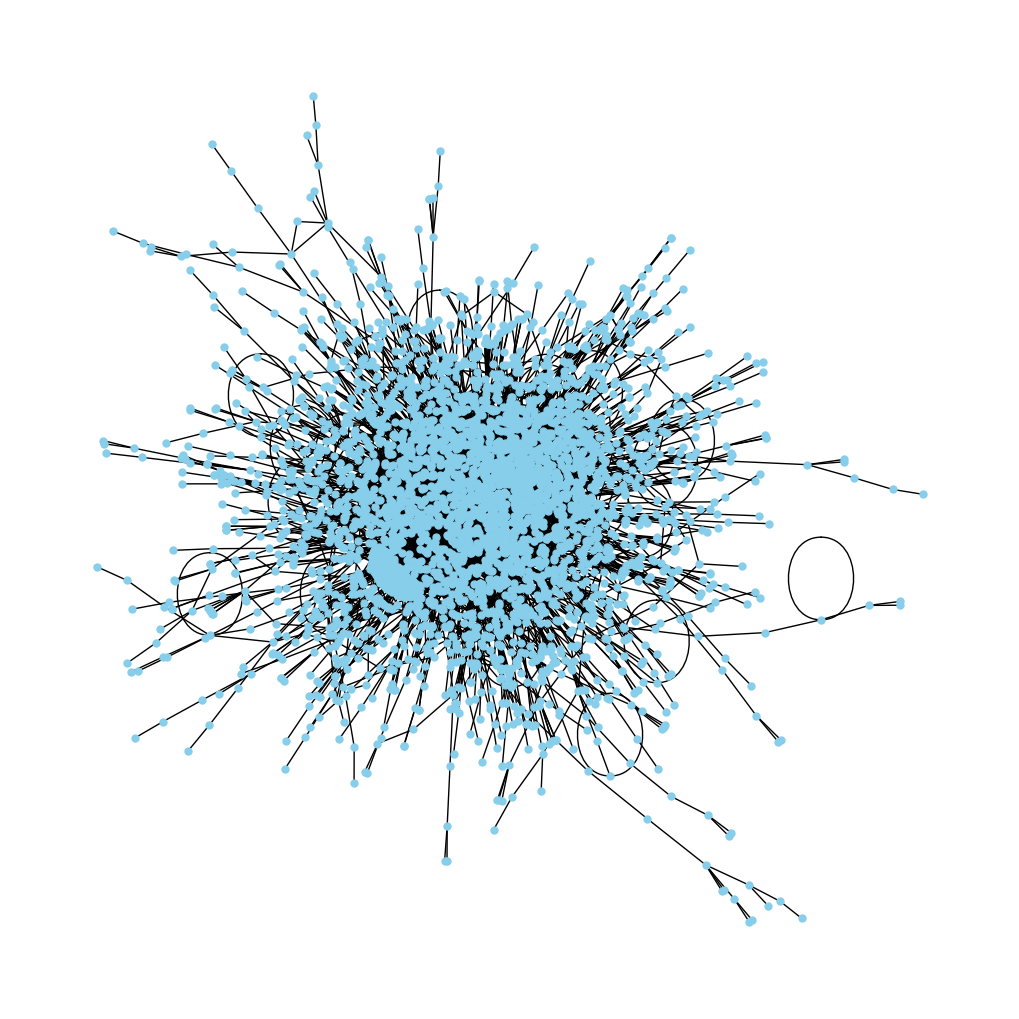

In [183]:
from torch_geometric.utils.convert import to_networkx
# Convert to NetworkX graph from PyTorch Geometric data object
test = to_networkx(data, to_undirected=True)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(test, with_labels=False, node_color='skyblue', node_size=25, edge_color='k')
plt.show()

## III - Data Modelling

In [39]:
X = train_set[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']]
y = train_set[['label']]
num_classes = 2
num_feat = X.shape[1]

G_dgl = dgl.from_networkx(G)
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long).squeeze()

In [96]:
num_edges = data.edge_index.size(1)

# Assuming the first half are positives (1s) and the second half are negatives (0s)
# Adjust this according to how you've actually prepared your data
labels = torch.cat([torch.ones(num_edges // 2), torch.zeros(num_edges // 2)], dim=0)

In [189]:
from torch_geometric.utils import negative_sampling

# Shuffle indices
perm = torch.randperm(num_edges)
train_size = int(0.8 * num_edges)
train_index = perm[:train_size]
test_index = perm[train_size:]

# Split the data
train_edge_index = data.edge_index[:, train_index]
test_edge_index = data.edge_index[:, test_index]

# Split the labels
train_labels = labels[train_index]
test_labels = labels[test_index]

### a) Random Baseline

In [57]:
###################
# random baseline #
###################

# Load test samples 
with open("../test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions
random_predictions = np.random.choice([0, 1], size=len(test_set))
random_pred = zip(np.array(range(len(test_set))), random_predictions)

# note: Kaggle requires that you add "ID" and "category" column headers

with open("random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in random_pred:
         csv_out.writerow(row)
    pred.close()
    
random_predictions

array([0, 0, 1, ..., 0, 1, 1])

### b) Logistic Regression

In [47]:
def edge_prediction(train_set, plot_roc=True):
    # Splitting the dataset into training and testing
    # This is a conceptual split. You might want to use a more sophisticated approach
    # such as cross-validation for a more robust evaluation
    msk = np.random.rand(len(train_set)) < 0.95
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
    test_features = test_samples[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values
    
    # --- Build the model and train it ---
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    
    test_preds_values = clf.predict(test_features)
    
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf

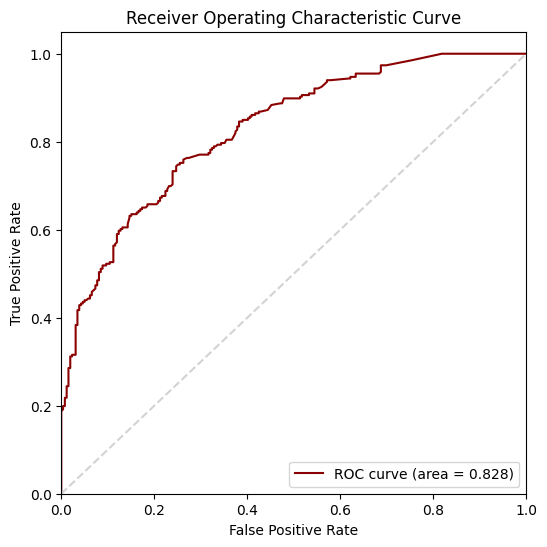

0.7352380952380952


In [48]:
roc_auc, test_accuracy, clf = edge_prediction(train_set)

print(test_accuracy)

In [64]:
test_features = test_set[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
test_preds_values = clf.predict(test_features)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

In [65]:
with open("clf_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()

### c) Graph Neural Network

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # Note: The prediction layer is often external to the model or differently handled.

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [14]:
def compute_edge_probabilities(node_embeddings, edge_index):
    # Extract embeddings for the source and target nodes of each edge
    source_embeddings = node_embeddings[edge_index[0]]
    target_embeddings = node_embeddings[edge_index[1]]

    # Compute similarity or dot product as a proxy for edge probability
    edge_scores = torch.sigmoid((source_embeddings * target_embeddings).sum(dim=-1))

    return edge_scores

In [15]:
import torch.optim as optim

model = GCN(num_features=data.num_features, hidden_channels=16)
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model to get node embeddings
    node_embeddings = model(data.x, data.edge_index)

    # Compute edge probabilities for positive samples
    pos_edge_probs = compute_edge_probabilities(node_embeddings, train_pos_edge_index)
    
    # Generate negative samples and compute edge probabilities for negative samples
    neg_edge_probs = compute_edge_probabilities(node_embeddings, train_neg_edge_index)
    
    # Compute loss
    total_edge_probs = torch.cat([pos_edge_probs, neg_edge_probs], dim=0)
    total_labels = torch.cat([torch.ones(pos_edge_probs.size(0)), torch.zeros(neg_edge_probs.size(0))], dim=0)
    loss = F.binary_cross_entropy(total_edge_probs, total_labels)
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item()

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        node_embeddings = model(data.x, data.edge_index)
        pos_edge_probs = compute_edge_probabilities(node_embeddings, pos_edge_index)
        neg_edge_probs = compute_edge_probabilities(node_embeddings, neg_edge_index)
        predictions = torch.cat([pos_edge_probs, neg_edge_probs], dim=0)
        labels = torch.cat([torch.ones(pos_edge_probs.size(0)), torch.zeros(neg_edge_probs.size(0))], dim=0)
        auc_score = roc_auc_score(labels.cpu().numpy(), predictions.cpu().numpy())
    return auc_score

# Actual training loop
for epoch in range(200):  # Adjust the number of epochs according to your needs
    loss = train()
    auc_score = test(val_pos_edge_index, val_neg_edge_index)  # Assuming validation sets are defined
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Val AUC: {auc_score:.4f}')

NameError: name 'train_pos_edge_index' is not defined

In [193]:
test_set['source'] = test_set['source'].apply(lambda x: node_mapping[x])
test_set['target'] = test_set['target'].apply(lambda x: node_mapping[x])

# Convert to edge_index format expected by PyTorch Geometric
test_edge_index = torch.tensor(test_set[['source', 'target']].values.T, dtype=torch.long)

In [111]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    test_pred = model(data.x, test_edge_index).squeeze()

# Convert predictions to probabilities using a sigmoid function (if not already done within the model)
test_pred_prob = torch.sigmoid(test_pred)

# You can set a threshold to classify edges as existing or not, e.g., threshold = 0.5
threshold = 0.5
predicted_links = (test_pred_prob >= threshold).int()

# Print or save your predictions
print(predicted_links)

tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)


In [113]:
predictions_df = pd.DataFrame(predicted_links, columns=['Predicted'])

# Export the DataFrame to a CSV file
predictions_df.to_csv('GCN_predictions.csv', index=False)

In [197]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, out_features):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=4, dropout=0.2)
        # Concatenation will happen on the output features so the dimension will increase
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, concat=True, dropout=0.2)
        # Since concat is set to True, the input features of the next layer are the hidden_channels * num_heads
        self.conv3 = GATConv(hidden_channels * 4, out_features, concat=False, heads=1, dropout=0.2)  # No concatenation in the final layer

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)  # Add dropout for regularization
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)  # Add dropout for regularization
        x = self.conv3(x, edge_index)
        return torch.sigmoid(x.squeeze())

model = GAT(num_node_features=data.num_node_features, hidden_channels=64, out_features=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    loss = train()
    test_loss, auc_score = test()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, AUC: {auc_score:.4f}')

ValueError: Using a target size (torch.Size([1050])) that is different to the input size (torch.Size([3498])) is deprecated. Please ensure they have the same size.

In [194]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    test_pred = model(data.x, test_edge_index).squeeze()

# Convert predictions to probabilities using a sigmoid function (if not already done within the model)
test_pred_prob = torch.sigmoid(test_pred)

# You can set a threshold to classify edges as existing or not, e.g., threshold = 0.5
threshold = 0.5
predicted_links = (test_pred_prob >= threshold).int()

# Print or save your predictions
print(predicted_links)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)


### e) XGBoost

In [133]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


/Users/victor/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


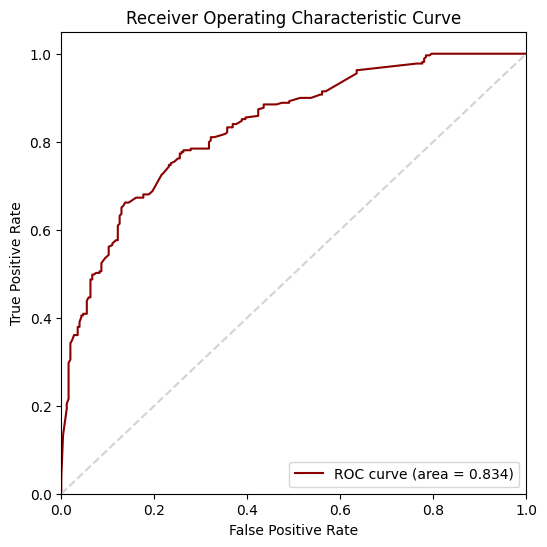

In [206]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

def edge_prediction_xgboost(train_set, plot_roc=True):
    # Splitting the dataset into training and testing
    msk = np.random.rand(len(train_set)) < 0.95
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
    test_features = test_samples[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values
    
    learning_rate = 0.001
    max_depth = 10         
    n_estimators = 500

    # --- Build the model and train it ---
    xgb_model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    xgb_model.fit(train_features, train_labels)

    train_preds = xgb_model.predict_proba(train_features)[:, 1]
    test_preds = xgb_model.predict_proba(test_features)[:, 1]
    
    # Predicting binary values for accuracy computation
    test_preds_values = xgb_model.predict(test_features)
    
    # Compute accuracy
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc, test_accuracy, clf
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf

# Usage
# train_set should be a DataFrame containing your features and label
 
roc_auc, test_accuracy, xgb = edge_prediction_xgboost(train_set)


In [151]:
print(test_accuracy)

0.7264748902974159


In [224]:
test_features = test_set[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
test_preds_values = xgb.predict(test_features)
print(test_preds_values)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

[0 0 0 ... 1 0 0]


In [223]:
for row in test_preds_values:
    print(row)

In [225]:
with open("xgboost_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()